In [1]:
## install SAM
# !pip install git+https://github.com/facebookresearch/segment-anything.git
# !wget -O ../sam_vit_h_4b8939.pth  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [2]:
import os
import cv2
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
sys.path.append('..')

import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from diffusers import DiffusionPipeline
from transformers import CLIPFeatureExtractor, CLIPModel
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

from utils import show_images, show_image

%load_ext autoreload
%autoreload 2

### Load CLIP model

In [3]:
feature_extractor = CLIPFeatureExtractor.from_pretrained(
    "laion/CLIP-ViT-B-32-laion2B-s34B-b79K"
)
clip_model = CLIPModel.from_pretrained(
    "laion/CLIP-ViT-B-32-laion2B-s34B-b79K", torch_dtype=torch.float16
)

/home/user/Projects/denk_baseline/venv/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


### Create DiffusionPipeline from local .py file

In [4]:
mixing_pipeline = DiffusionPipeline.from_pretrained(
#     "CompVis/stable-diffusion-v1-4",
    "stabilityai/stable-diffusion-2-base",
    custom_pipeline="../images_mixing.py",
    clip_model=clip_model,
    feature_extractor=feature_extractor,
    torch_dtype=torch.float16,
)
mixing_pipeline = mixing_pipeline.to("cuda")

In [5]:
sam_checkpoint = "../sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device="cuda")

predictor = SamPredictor(sam)

In [6]:
content_image = Image.open('../images/rzd_worker.jpg').convert("RGB")
style_image = Image.open('../images/winter.jpg').convert("RGB")

def apply_mask_with_gauss(bg_img, src_img, mask):
    mask = mask.astype(np.float32)
    b_mask = cv2.GaussianBlur(mask, (7, 7), 0)
    b_mask = b_mask[:,:, None]
    out_image = bg_img.astype(np.float32) * (1.0 - b_mask) + src_img.astype(np.float32) * b_mask
    out_image = np.clip(out_image, 0, 255).astype(np.uint8)
    return out_image

def get_mask_for_box(img_h, img_w, box):
    x1, y1, x2, y2 = box
    mask = np.zeros((img_h, img_w), dtype=np.uint8)
    mask[y1:y2, x1:x2] = 1
    return mask.astype(bool)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
       
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

In [7]:
c_image = np.array(content_image).copy()
h, w = c_image.shape[:2]

rect_person = [185, 75, 340, 550]
rect_tool = [185, 0, 285, 120]
person_mask = get_mask_for_box(h, w, rect_person)
tool_mask = get_mask_for_box(h, w, rect_tool)
mask = person_mask | tool_mask

# c_image[person_mask] = (c_image[person_mask]*0.5).astype(np.uint8)
# c_image[tool_mask] = (c_image[tool_mask]*0.5).astype(np.uint8)

# c_image[mask] = (c_image[mask]*0.5).astype(np.uint8)

# show_image(c_image, title=f'{h}x{w}', figsize=(15, 10))

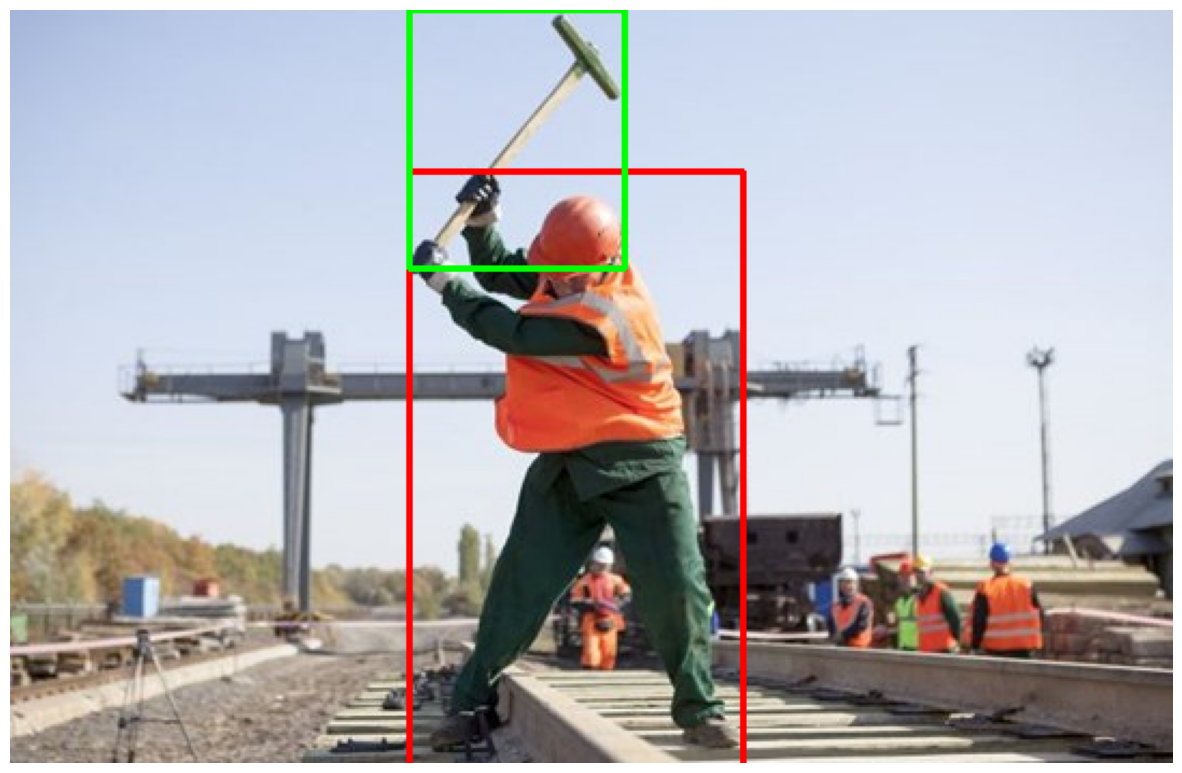

In [8]:
rect_img = np.array(content_image).copy()
rect_img = cv2.rectangle(rect_img, (rect_person[0], rect_person[1]), (rect_person[2], rect_person[3]), (255, 0, 0), 2, 1)
rect_img = cv2.rectangle(rect_img, (rect_tool[0], rect_tool[1]), (rect_tool[2], rect_tool[3]), (0, 255, 0), 2, 1)
show_image(rect_img, figsize=(15, 10))

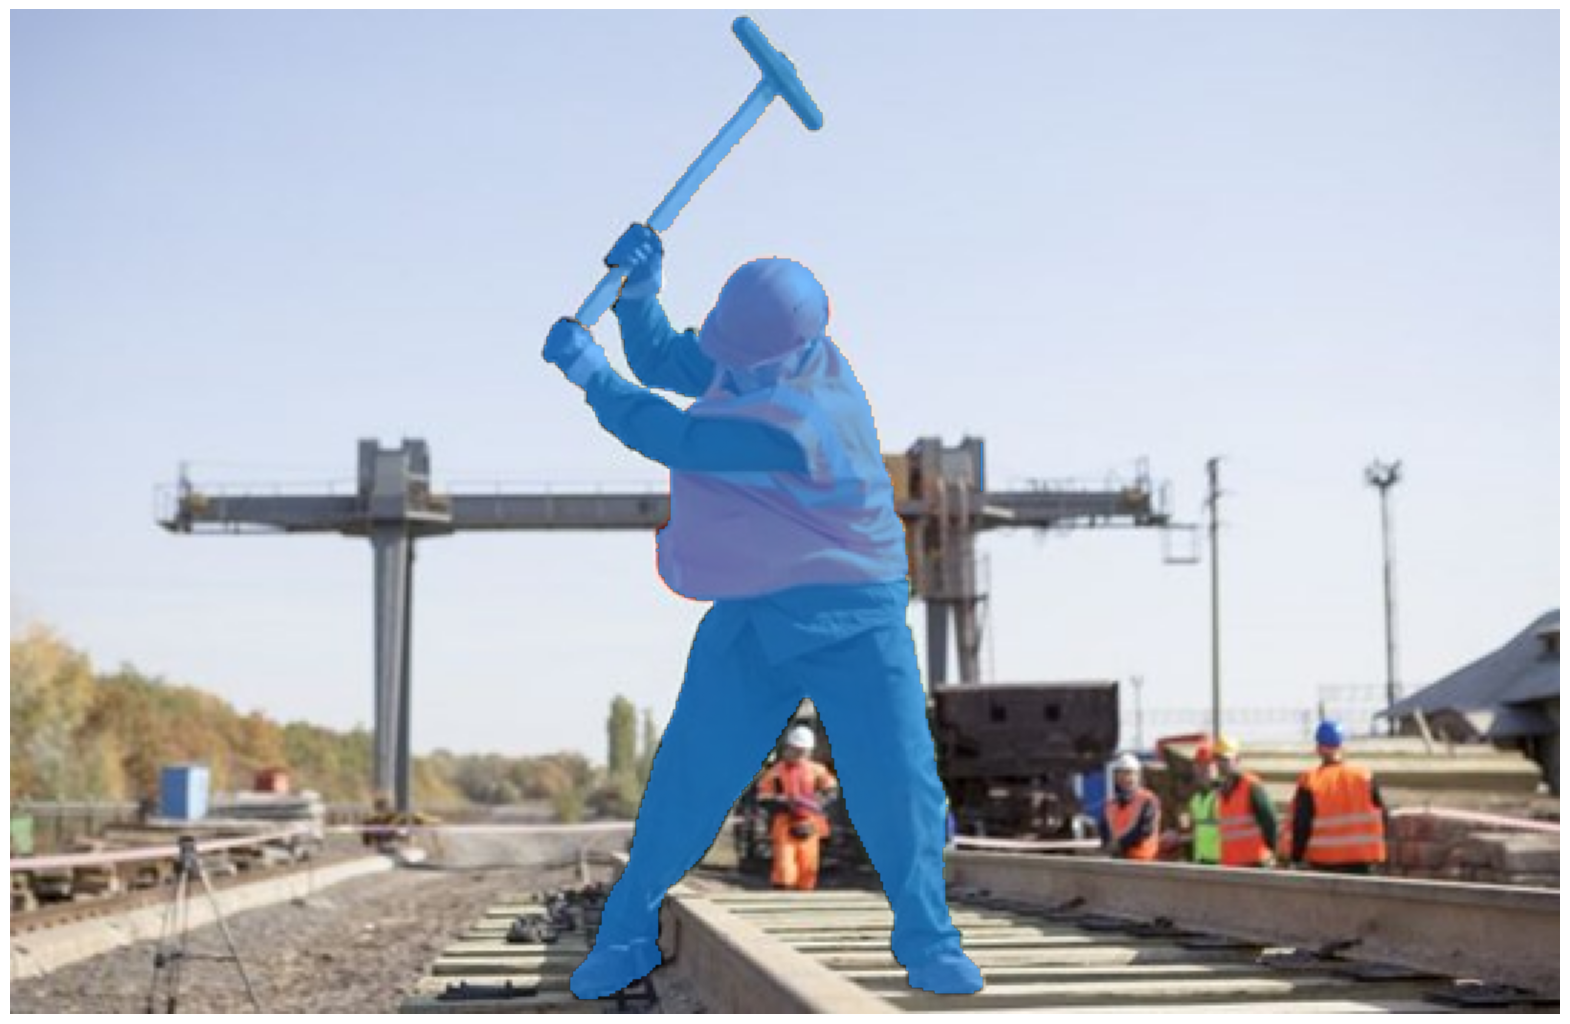

In [9]:
boxes_persons = [rect_person]
boxes_tools = [rect_tool]

image = np.array(content_image)
img_h, img_w = image.shape[:2]

general_masks = np.zeros((img_h, img_w), dtype=bool)

predictor.set_image(image)
for box in boxes_persons + boxes_tools: 
    input_box = np.array(box)
    
    masks, _, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_box[None, :],
        multimask_output=False,
    )
    general_masks = general_masks | masks[0]

plt.figure(figsize=(20, 15))
plt.imshow(content_image)
show_mask(general_masks, plt.gca())
# show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

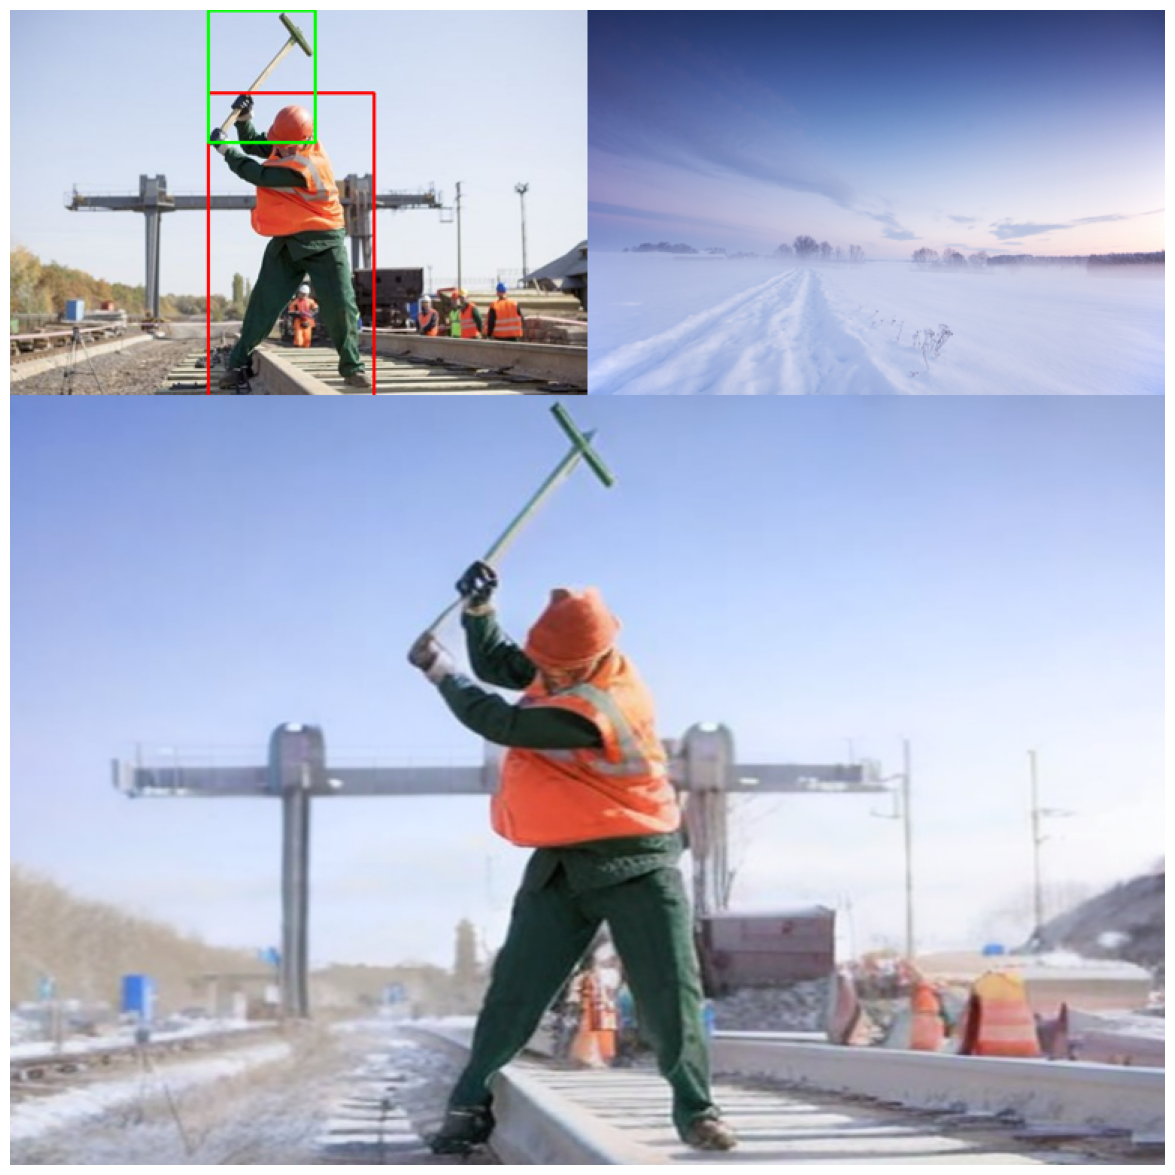

In [10]:
generator = torch.Generator(device="cuda").manual_seed(17) 

pipe_images = mixing_pipeline(
    num_inference_steps=50,
    content_prompt='man, winter, railway road', 
    style_prompt='man, winter, railway road',
    content_image=content_image,
    style_image=style_image,
    noise_strength=0.2,
    slerp_latent_style_strength=0.3,
    slerp_prompt_style_strength=0.9,
    slerp_clip_image_style_strength=0.9,
    guidance_scale=9.0,
    batch_size=1,
    clip_guidance_scale=100,
    generator=generator,
    mask=torch.from_numpy(general_masks).unsqueeze(0).unsqueeze(0).float(),
    object_noise_coef=0.4,
).images

raw_content_image = np.array(content_image.resize((768, 512)))
raw_general_masks = cv2.resize(general_masks.astype(np.uint8), (768, 512), interpolation=cv2.INTER_NEAREST).astype(bool)

p_image = np.array(pipe_images[0].resize((768, 512)))
# p_image[raw_general_masks] = raw_content_image[raw_general_masks]

source_images = [Image.fromarray(rect_img), style_image]
h_images = np.hstack([np.array(x.resize((384, 256))) for x in source_images])

s_image = np.vstack([h_images, p_image])

show_images([s_image], figsize=(15, 15))

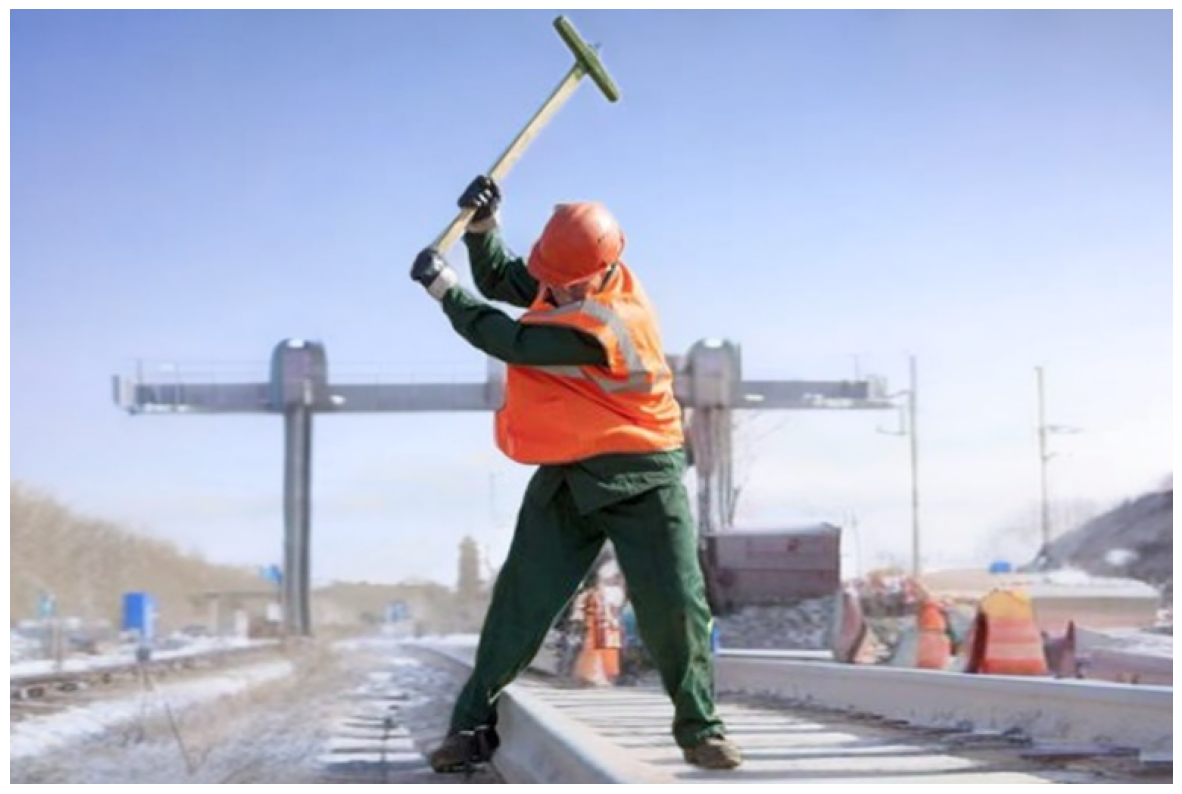

In [11]:
result_image = apply_mask_with_gauss(p_image, raw_content_image, raw_general_masks)
show_images([result_image], figsize=(15, 15))